#**Analysis of sports data using pyspark**


# 1. Initialize pyspark framework and load data into pyspark's dataframe




The dataset we use is from : Datasource: https://sites.google.com/eng.ucsd.edu/fitrec-project/home 

This dataset is about calculating the heart rate of people, along with other relating features: gender, weather condition, sport type, GPS, etc

In [1]:
!pip install pyspark;

In [2]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [3]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
filename_data = "/content/drive/My Drive/BD/endomondoHR.json"
# Load the main data set into pyspark data frame 
df = spark.read.json(filename_data, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# 2. Overview of Dataset

The data set has both single value columns (int, string) and columns made of arrays/list.

In [6]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- altitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- gender: string (nullable = true)
 |-- heart_rate: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- id: long (nullable = true)
 |-- latitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- longitude: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- speed: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- sport: string (nullable = true)
 |-- timestamp: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- url: string (nullable = true)
 |-- userId: long (nullable = true)

Columns overview


,Column Name,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


In [7]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print(f'There are total {df.count()} row, Let print first 2 data rows:')
df.limit(2).toPandas()

Data frame describe (string and numeric columns only):


,summary,gender,id,sport,url,userId
0,count,253020,253020,253020,253020,253020
1,mean,None,3.566244412926132E8,None,None,4619648.939783417
2,stddev,None,1.574845634895318E8,None,None,3932877.7296880507
3,min,female,99296,aerobics,https://www.endomondo.com/users/10014612/worko...,69
4,max,unknown,674008008,yoga,https://www.endomondo.com/users/9991401/workou...,15481421


There are total 253020 row, Let print first 2 data rows:


,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915


# 3. Detect missing values and abnormal zeroes



In [8]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,altitude,array<double>
1,gender,string
2,heart_rate,array<bigint>
3,id,bigint
4,latitude,array<double>
5,longitude,array<double>
6,speed,array<double>
7,sport,string
8,timestamp,array<bigint>
9,url,string


In [9]:
string_columns = ['gender', 'sport', 'url']
numeric_columns = ['id','userId']
array_columns = ['altitude', 'heart_rate', 'latitude', 'longitude', 'speed', 'timestamp']
missing_values = {} 
for index, column in enumerate(df.columns):
    if column in string_columns:    # check string columns with None and Null values
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_columns:  # check zeroes, None, NaN
        missing_count = df.where(col(column).isin([0,None,np.nan])).count()
        missing_values.update({column:missing_count})
    if column in array_columns:  # check zeros and NaN
        missing_count = df.filter(array_contains(df[column], 0) | array_contains(df[column], np.nan)).count()
        missing_values.update({column:missing_count})
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df

,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId
0,40848,0,1280,0,113,113,7741,0,0,0,0


In [10]:
# Create new column to count the number of timestamps recorded per row/workout, named as 'PerWorkoutRecordCount' column
df = df.withColumn('PerWorkoutRecordCount', size(col('timestamp')))

def user_activity_workout_summarize(df):
    user_count = format(df.select('userId').distinct().count(), ',d')
    workout_count = format(df.select('id').distinct().count(), ',d')
    activity_count = str(df.select('sport').distinct().count())
    sum_temp = df.agg(functions.sum('PerWorkoutRecordCount')).toPandas()
    total_records_count = format(sum_temp['sum(PerWorkoutRecordCount)'][0],',d')
    columns=['Users count', 'Activity types count','Workouts count', 'Total records count']
    data = [[user_count], [activity_count], [workout_count], [total_records_count]]
    sum_dict = {column: data[i] for i, column in enumerate(columns)}
    sum_df = pd.DataFrame.from_dict(sum_dict)[columns]
    gender_user_count = df.select('gender','userId').distinct().groupBy('gender').count().toPandas()
    gender_activities_count = df.groupBy('gender').count().toPandas()
    gender_user_activity_count = gender_user_count.join(
        gender_activities_count.set_index('gender'), on='gender'
        , how='inner', lsuffix='_gu'
    )
    gender_user_activity_count.columns = ['Gender', '# of users', 'Activities (workouts) count']
    
    return sum_df, gender_user_activity_count

sum_dfs= user_activity_workout_summarize(df)
print('\nOverall data set summary on users, workouts and number of records (pre-filtering):')
sum_dfs[0]


Overall data set summary on users, workouts and number of records (pre-filtering):


,Users count,Activity types count,Workouts count,Total records count
0,"1,104",49,"253,020","111,541,956"


The total records for this dataset is over 111M records. It's really large size

In [11]:
print('Number of workouts that have less than 50 records and statistic summary:')
removed_df = df.select('PerWorkoutRecordCount').where(df.PerWorkoutRecordCount < 50) \
               .toPandas().describe().astype(int)
removed_df.rename(columns = {'PerWorkoutRecordCount': 'PerWorkoutRecordCount <50'}, inplace=True)
removed_df.T

Number of workouts that have less than 50 records and statistic summary:


,count,mean,std,min,25%,50%,75%,max
PerWorkoutRecordCount <50,5541,23,14,1,11,22,36,49


# 4. Pyspark lazy evaluation

lazy evaluation in Spark means that the execution will not start until an action is triggered. In Spark, the picture of lazy evaluation comes when Spark transformations occur.

Lazy evaluation enhances the power of Apache Spark by reducing the execution time of the RDD operations. It maintains the lineage graph to remember the operations on RDD. we can simply remember that all processing in Pyspark is abstraction, When we want to return the results, actually we tell Spark what is the eventual answer you're interested and it figures out best way to get there. As a result, it optimizes the performance and achieves fault tolerance.

In order to see the result, we have to call Spark.collect().

Normolly, we can show the results with the syntax: df.take(k) or df.limit(k) to get the results with k row.

When K become large number, These 2 way above takes a long time to complete the process. Because this syntax above did not utilize the power of Pyspark processing (Lazy evaluation). In order to quickly processing , We should use df.collect()[:k] to return the k row as we want.

In [12]:
ranked_sport_users_df = df.select(df.sport, df.userId) \
    .distinct() \
    .groupBy(df.sport) \
    .count() \
    .orderBy("count", ascending=False)

# Top 5 workout types
highest_sport_users_df = ranked_sport_users_df.limit(5).toPandas()
# Rename column name : 'count' --> Users count
highest_sport_users_df.rename(columns = {'count':'Users count'}, inplace = True)
# Caculate the total users, this result will bw used to compute percentage later
total_sports_users = ranked_sport_users_df.groupBy().sum().collect()[0][0]

In [13]:
ranked_sport_users_df.collect()[:5]

[Row(sport='run', count=865),
 Row(sport='bike', count=794),
 Row(sport='mountain bike', count=336),
 Row(sport='bike (transport)', count=252),
 Row(sport='walk', count=209)]

# 5. Explolatory Data analysis

Some chart indicate the top 5 workout types as we evaluated above

Top 5 sports that have the most users participated:


,sport,Users count,percentage
0,run,865,25.130738
1,bike,794,23.067984
2,mountain bike,336,9.761766
3,bike (transport),252,7.321325
4,walk,209,6.072051
5,others,986,28.646136


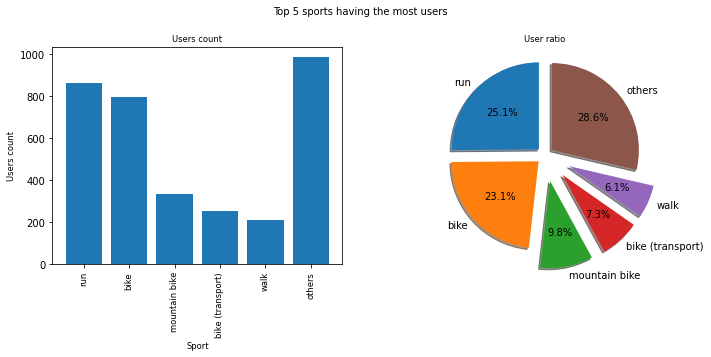

In [14]:
highest_sport_users_df_renamed = highest_sport_users_df
# Compute the percentage of top 5 workout type / total users
highest_sport_users_df_renamed['percentage'] = highest_sport_users_df['Users count'] \
    / total_sports_users * 100

# Rest of users belong to another specific group called 'others'
others = {
      'sport': 'others'
    , 'Users count': total_sports_users - sum(highest_sport_users_df_renamed['Users count'])
    , 'percentage': 100 - sum(highest_sport_users_df_renamed['percentage'])
}

highest_sport_users_df_renamed = highest_sport_users_df_renamed.append(
    others, ignore_index=True
)
print('Top 5 sports that have the most users participated:')
highest_sport_users_df_renamed

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 =   axs[0].bar(x=highest_sport_users_df_renamed['sport']
                     , height=highest_sport_users_df_renamed['Users count'])
title0 =  axs[0].set_title('Users count', fontsize = 'small')
xlabel0 = axs[0].set_xlabel('Sport', fontsize = 'small')
ylabel0 = axs[0].set_ylabel('Users count', fontsize = 'small')
xsticks_label = axs[0].set_xticklabels(highest_sport_users_df_renamed['sport'] 
                                       ,rotation = 'vertical', fontsize='small')
explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.1)
title1 = axs[1].set_title('User ratio', fontsize = 'small')
plot1 = axs[1].pie(
      x=highest_sport_users_df_renamed['percentage']
    , labels=highest_sport_users_df_renamed['sport']
    , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
    , radius=1
)

text = fig.text(0.5, 1.02, 'Top 5 sports having the most users', ha='center', va='top', transform=fig.transFigure)

The data shows that running, walking and biking-related activities are the most spent by users, which is quite reasonable due to those exercises' convenience without much investment :3

In [15]:
activities_by_gender = df.groupBy('sport', 'gender').count().toPandas() 
activities_by_gender[:5]

,sport,gender,count
0,treadmill walking,male,2
1,step counter,male,2
2,swimming,unknown,8
3,fitness walking,male,228
4,circuit training,female,22


# 6. UNSTACK PYSPARK DATAFRAME

There are total: 49 activities and here is the chart for activities based on gender:


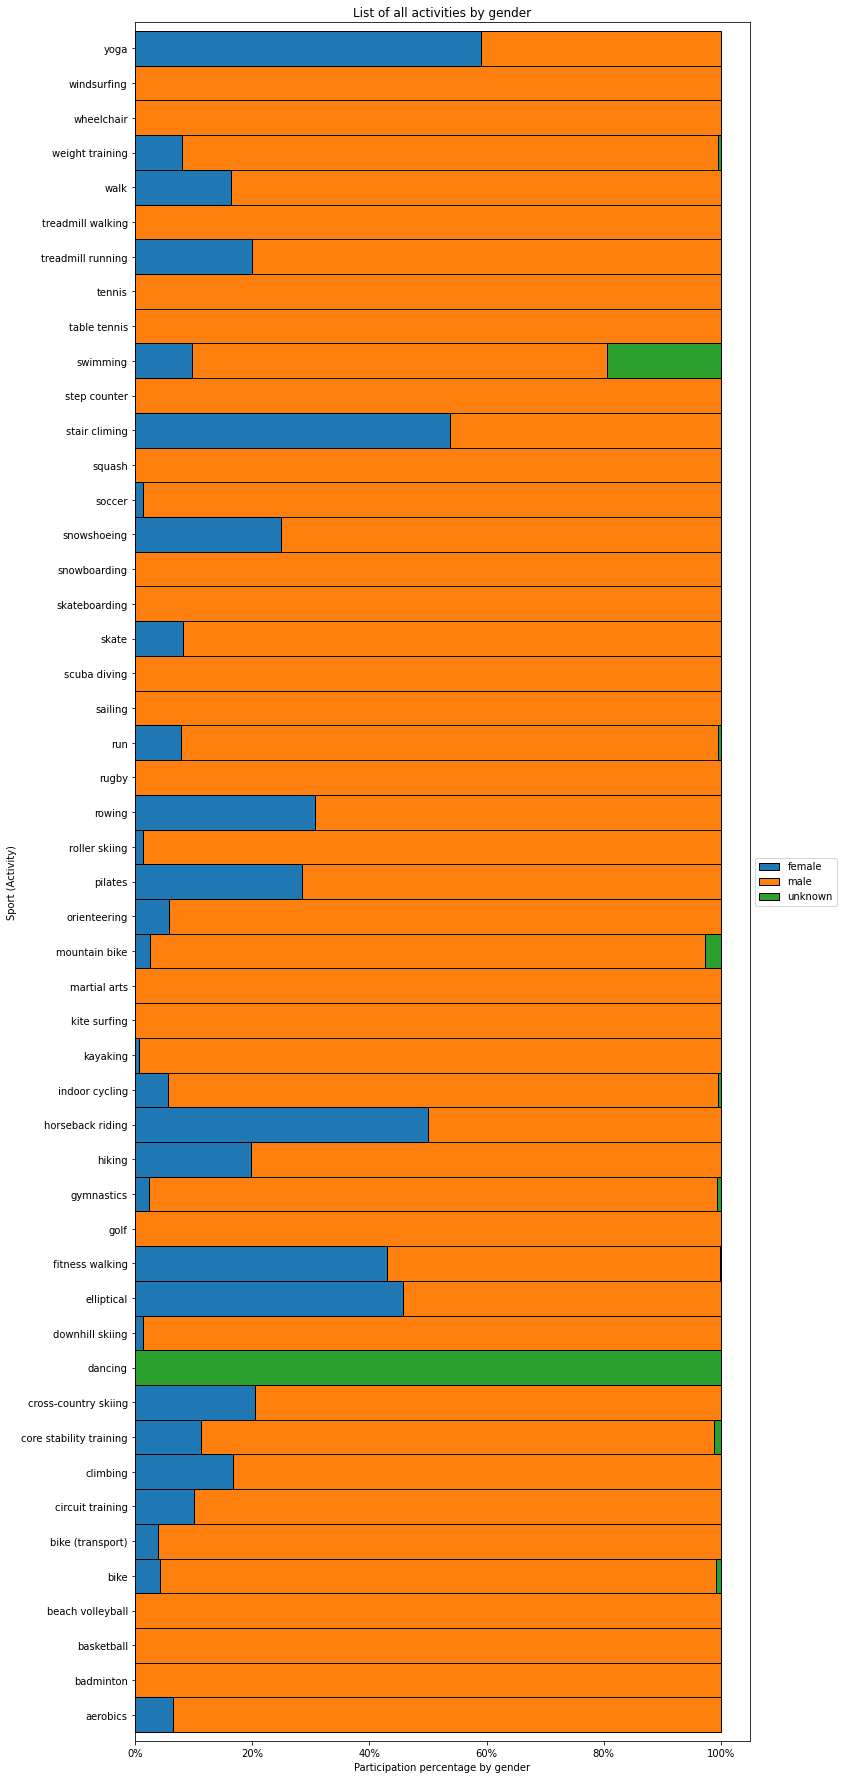

In [16]:
total_activities = ranked_sport_users_df.count()
print(f'There are total: {total_activities} activities and here is the chart for activities based on gender:')
# Add the infor of activities based on gender
activities_by_gender = df.groupBy('sport', 'gender').count().toPandas()
# Visualize
fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = activities_by_gender.groupby(['sport', 'gender']).agg(np.mean).groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', stacked=True, width=1  ## APPLY UNSTACK TO RESHAPE DATA
                , edgecolor='black', ax=ax, title='List of all activities by gender')
ylabel = plt.ylabel('Sport (Activity)');
xlabel = plt.xlabel('Participation percentage by gender');
legend = plt.legend(
    sorted(activities_by_gender['gender'].unique()), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

,sport,female,male,unknown,total,percentage
0,run,9360,107882,660,117902,46.597897
1,bike,4172,92966,863,98001,38.732511
2,mountain bike,353,12782,375,13510,5.339499
3,bike (transport),414,10030,1,10445,4.128132
5,others,1034,8255,42,9331,3.687851
4,walk,626,3204,1,3831,1.514110


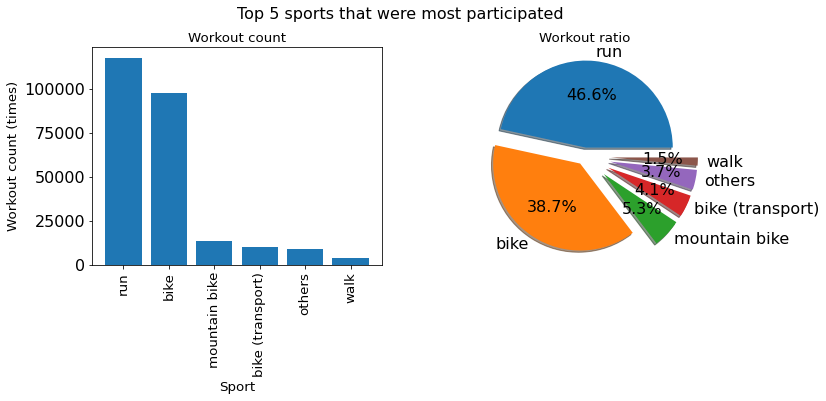

In [17]:
activities_by_gender_df = activities_by_gender.pivot_table(
    index="sport", columns="gender", values='count', fill_value=0) \
    .reset_index().rename_axis(None, axis=1)

activities_by_gender_df['total'] = activities_by_gender_df['male'] \
        + activities_by_gender_df['female'] \
        + activities_by_gender_df['unknown']
activities_by_gender_df['percentage'] = activities_by_gender_df['total'] \
    / sum(activities_by_gender_df['total']) * 100
top_activities_by_gender_df = activities_by_gender_df.sort_values(
    by='percentage', ascending=False
).head(5)

others = {'sport' : 'others'}
for column in ['female', 'male', 'unknown', 'total', 'percentage']:
    value = sum(activities_by_gender_df[column]) - sum(top_activities_by_gender_df[column])
    others.update({column: value})
top_activities_by_gender_df = top_activities_by_gender_df.append(others, ignore_index=True)
top_activities_by_gender_df = top_activities_by_gender_df.sort_values(
    by='percentage', ascending=False
)
top_activities_by_gender_df

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 = axs[0].bar(x=top_activities_by_gender_df['sport']
                   , height=top_activities_by_gender_df['total'])
title0 = axs[0].set_title('Workout count', fontsize='small')
xlabel0 = axs[0].set_xlabel('Sport', fontsize='small')
ylabel0 = axs[0].set_ylabel('Workout count (times)', fontsize='small')
xsticks_label = axs[0].set_xticklabels(top_activities_by_gender_df['sport']
                                       , rotation='vertical', fontsize='small')
explode = (0.1, 0.1, 0.3, 0.3, 0.3, 0.3)
title1 = axs[1].set_title('Workout ratio', fontsize = 'small')
plot1 = axs[1].pie(
    x=top_activities_by_gender_df['percentage']
    , labels=top_activities_by_gender_df['sport']
    , autopct='%1.1f%%', shadow=True, explode=explode, radius=1
)

text = fig.text(0.5, 1.02, 'Top 5 sports that were most participated'
                , ha='center', va='top', transform=fig.transFigure)

Once again, similar to the user participation, running, walking and biking are also the dominant contribution interm of number of workout counts. However, the only different is that pure running and biking activities count is much bigger than those of the remaining sports, and the total count of those 2 already take up to more than 85% of total activities. 

In [18]:
min_number_of_sports = 1

sport_df = df \
    .select(df.userId, df.gender, df.sport) \
    .distinct() \
    .groupBy(df.userId, df.gender) \
    .count()    

user_more_sports_df = sport_df \
                    .filter(sport_df["count"] > min_number_of_sports) \
                    .orderBy("count", ascending = False) \
                    .toPandas()
user_more_sports_df.rename(columns = {'count':'Sports count'}, inplace = True)
user_more_sports_df.describe().astype(int).T

,count,mean,std,min,25%,50%,75%,max
userId,822,4860464,3953412,69,1609606,3730685,7554937,15481421
Sports count,822,3,2,2,2,3,5,16


Based on the summary, there are 822 persons participated more than 1 sport. Among them in average a person take part in about 3 sports and there is some person playing up to 16 sports!


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


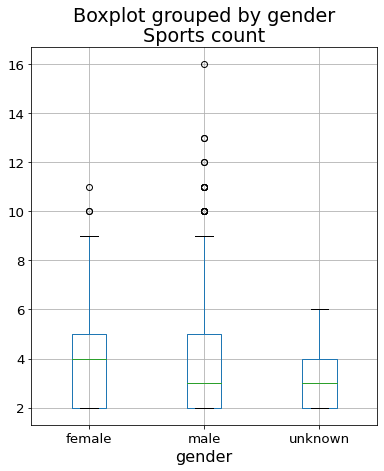

In [19]:
plot = user_more_sports_df.boxplot(column='Sports count', by='gender', fontsize='small', figsize=(6,7))

The boxplot showed that except the outliers, both males and females have nearly the same distribution of sport participation.

# 7. Pyspark UDF Registering


In [23]:
# LOOK AGAIN THE TIMESTAMP COLUMN
df.limit(3).toPandas()

,altitude,gender,heart_rate,id,latitude,longitude,speed,sport,timestamp,url,userId,PerWorkoutRecordCount
0,"[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....",male,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",396826535,"[60.173348765820265, 60.173239801079035, 60.17...","[24.64977040886879, 24.65014273300767, 24.6509...","[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3...",bike,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915,500
1,"[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....",male,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",392337038,"[60.173247596248984, 60.17320962622762, 60.172...","[24.649855233728886, 24.65015547350049, 24.650...","[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30...",bike,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915,500
2,"[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....",male,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",389643739,"[60.17326201312244, 60.173205351457, 60.172969...","[24.64995657093823, 24.650197718292475, 24.651...","[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3...",bike,"[1407858459, 1407858466, 1407858478, 140785849...",https://www.endomondo.com/users/10921915/worko...,10921915,500


##  4 helper function were created for 'timestamp' column as described above then convert them to UDF

In [24]:
# Convert a timestamp column into Datetime.Datetime, to be used for .withColumn function later
def to_time(timestamp_list):
    # convert to datetime and minus 7 hours due to the difference in Endomondo time window with utc time as the dataset description
    return [datetime.fromtimestamp(t) - timedelta(hours=7) for t in timestamp_list]

# Register 'to_time' function into UDF pyspark framework
udf_to_time = udf(to_time, ArrayType(elementType=TimestampType()))

# Support function to get the duration (in minutes) of a list of datetime values, to be used for withColumn function later
def get_duration(datetime_list):
    time_dif = max(datetime_list) - min(datetime_list)
    return time_dif.seconds/60

# Register the support function 'get_duration' as a user defined function into pyspark framework
udf_get_duration = udf(get_duration, FloatType())

# Support function to get the workout start time of the datetime list, to be used for withColumn function later
def get_start_time(datetime_list):
    return min(datetime_list)

# Register the support function 'get_start_time' as a user defined function into pyspark framework
udf_get_start_time = udf(get_start_time, TimestampType())

# Support function to get list of intervals within a workout
def get_interval(datetime_list):
    if len(datetime_list) == 1:
        return [0]
    else:
        interval_list = []
        for i in range(0, len(datetime_list)-1):
            interval = (datetime_list[i+1] - datetime_list[i]).seconds
            interval_list.append(interval)
        return interval_list

# Register the support function 'get_interval' as a user defined function into pyspark framework    
udf_get_interval = udf(get_interval, ArrayType(elementType=IntegerType()))

# Create new 'date_time' column to convert from timestamp into python's datetime format for later usage
df = df.withColumn('date_time', 
    udf_to_time('timestamp'))

# Create 'workout_start_time' column to get the start time of each workout/row:
df = df.withColumn('workout_start_time', hour(udf_get_start_time('date_time')))

# Create duration column from the date_time column just created, using the udf function udf_get_duration defined above
df = df.withColumn('duration', udf_get_duration('date_time'))

# Create interval column from the date_time column, using the udf function udf_get_interval defined above
df = df.withColumn('interval', udf_get_interval('date_time'))

print('New columns (''date_time'', ''workout_start_time'' in hour\
, ''duration'' in minutes & ''interval'' in seconds)\n, first 5 rows:')
df.select('timestamp','date_time', 'workout_start_time', 'duration', 'interval').limit(5).toPandas()



New columns (date_time, workout_start_time in hour, duration in minutes & interval in seconds)
, first 5 rows:


,timestamp,date_time,workout_start_time,duration,interval
0,"[1408898746, 1408898754, 1408898765, 140889877...","[2014-08-24 09:45:46, 2014-08-24 09:45:54, 201...",9,126.483330,"[8, 11, 13, 16, 6, 23, 16, 23, 29, 23, 24, 24,..."
1,"[1408221682, 1408221687, 1408221699, 140822170...","[2014-08-16 13:41:22, 2014-08-16 13:41:27, 201...",13,74.000000,"[5, 12, 8, 4, 5, 6, 4, 4, 5, 13, 7, 17, 4, 10,..."
2,"[1407858459, 1407858466, 1407858478, 140785849...","[2014-08-12 08:47:39, 2014-08-12 08:47:46, 201...",8,112.483330,"[7, 12, 12, 16, 6, 7, 16, 11, 19, 13, 17, 11, ..."
3,"[1407432042, 1407432048, 1407432056, 140743206...","[2014-08-07 10:20:42, 2014-08-07 10:20:48, 201...",10,75.316666,"[6, 8, 9, 4, 13, 4, 3, 4, 13, 10, 13, 13, 7, 1..."
4,"[1406909434, 1406909436, 1406909437, 140690943...","[2014-08-01 09:10:34, 2014-08-01 09:10:36, 201...",9,22.616667,"[2, 1, 1, 3, 2, 1, 4, 2, 1, 2, 1, 1, 2, 4, 4, ..."


##  duration of each workout (in minutes). First is some typical statistics.

In [25]:
print('\nLet''s look at the statistics of the new duration column (in minutes):')
df.select('duration').toPandas().describe().T


Lets look at the statistics of the new duration column (in minutes):


,count,mean,std,min,25%,50%,75%,max
duration,253020.0,84.484848,98.089287,0.0,32.166668,58.916668,102.73333,1439.966675


From the statistic of `duration` column, it can be observed that workout duration can last from 0 minute and up to 1 full day (1440 minutes = 24 hours). The duration of 0 might be for workouts that only have 1 single record only, so the min and the max timestamp would be the same



Plotting distribution of duration per sport type:


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/hist.py:403: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,


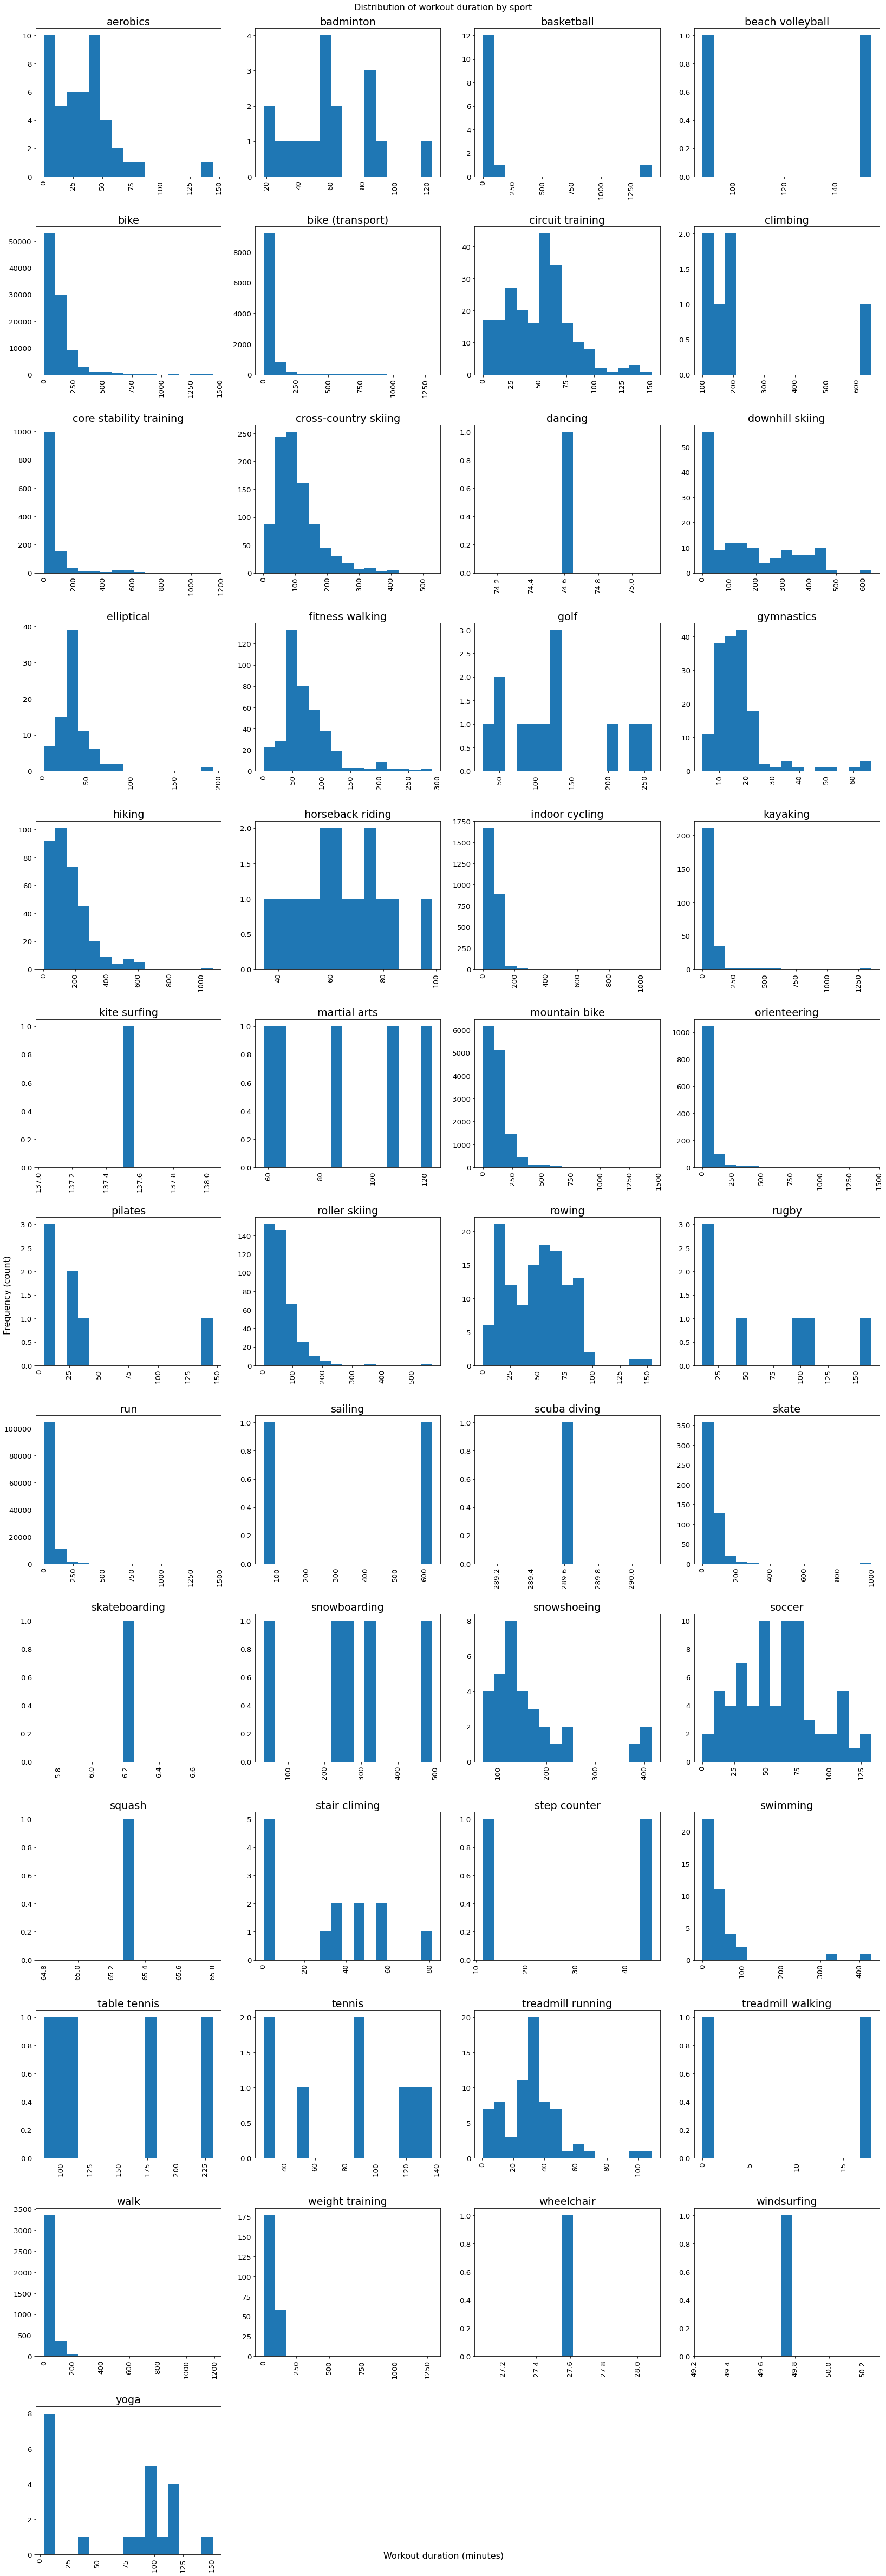

In [26]:
print('\nPlotting distribution of duration per sport type:')
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = plot_size_x * 4 +3, plot_size_y * 13 + 1
figsize = (figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (13,4)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)

duration_dist = df.select('duration', 'sport').toPandas().hist(
    column='duration', by='sport', bins=15, sharex = False, grid=True
    , xlabelsize='small', ylabelsize='small' , ax = ax
    , layout = grid_size, figsize=figsize
    )
a = fig.tight_layout()
title = fig.text(0.5, 1, 'Distribution of workout duration by sport'
             , ha='center', va='center', transform=fig.transFigure
            )
xlabel = fig.text(0.5, 0.01, 'Workout duration (minutes)'
             , ha='center', va='center', transform=fig.transFigure)
ylabel = fig.text(0.01, 0.5, 'Frequency (count)', va='center', rotation='vertical');

*From the duration summary & distribution plot, majority of the activities happens in 1-2 hours, only a few sports with a few cases each type happened in longer durations, such as moutain bike, hiking, sailing, etc..*

# 8. Convert row objects to Spark Resilient Distributed Dataset (RDD)

Convert the row object to RDD format in Pyspark through:

The advanced of RDD format is: Each data set is divided into logical parts and these can be easily computed on different nodes of the cluster. They can be operated in parallel and are fault-tolerant, so that the process is stable and very fast

In [27]:
def calculate_stats(x,column_name, stat_list):
    sport, records_list = x
    stat_dict = {'sport': sport}
    if 'min' in stat_list:
        min_stat = min(records_list)
        stat_dict.update({'min ' + column_name : min_stat})
    if 'max' in stat_list:
        max_stat = max(records_list)
        stat_dict.update({'max ' + column_name: max_stat})
    if 'mean' in stat_list:
        average_stat = stats.mean(records_list)
        stat_dict.update({'mean ' + column_name: average_stat})
    if 'stdev' in stat_list:
        std_stat = stats.stdev(records_list)
        stat_dict.update({'stdev ' + column_name: std_stat})
    if '50th percentile' in stat_list:
        median_stat = stats.median(records_list)
        stat_dict.update({'50th percentile ' + column_name: median_stat})
    if '25th percentile' in stat_list:
        percentile_25th_stat = np.percentile(records_list, 25)
        stat_dict.update({'25th percentile ' + column_name: percentile_25th_stat})
    if '75th percentile' in stat_list:
        percentile_75th_stat = np.percentile(records_list, 75)
        stat_dict.update({'75th percentile ' + column_name: percentile_75th_stat})
    if '95th percentile' in stat_list:
        percentile_95th_stat = np.percentile(records_list, 95)
        stat_dict.update({'95th percentile ' + column_name: percentile_95th_stat})
    return stat_dict

def to_list(a):
    return a

def extend(a, b):
    a.extend(b)
    return a

def retrieve_array_column_stat_df(df, column_name, stat_list):
    # Convert sport & "column_name" to RDD to easily calculate the statistics of intervals by sports
    sport_record_rdd = df.select('sport', column_name).rdd \
    .map(tuple).combineByKey(to_list, extend, extend).persist()

    # Calculate statistics of the input column by calling calculate_stats function defined above
    record_statistic_df = pd.DataFrame(sport_record_rdd.map(
        lambda x: calculate_stats(x, column_name,stat_list)).collect()
                                      )
    # Set proper dataframe column orders
    columns_order = ['sport'] + [stat + ' ' + column_name for stat in stat_list]
    # Re order columns
    return record_statistic_df[columns_order]

stat_list = ['min', '25th percentile', 'mean', '50th percentile',
                     '75th percentile', '95th percentile', 'max', 'stdev']
interval_statistic_df = retrieve_array_column_stat_df(df, column_name='interval', stat_list=stat_list)
print('\nLet\'s look at statistic for interval, in seconds (by sport):' )
interval_statistic_df


Let's look at statistic for interval, in seconds (by sport):


,sport,min interval,25th percentile interval,mean interval,50th percentile interval,75th percentile interval,95th percentile interval,max interval,stdev interval
0,walk,0,3.0,7.912633,5.0,8.00,18.00,86399,194.586603
1,treadmill running,0,2.0,5.513624,4.0,6.00,13.00,683,10.635236
2,yoga,0,3.0,18.114438,7.0,19.00,70.00,1170,39.695865
3,bike (transport),0,3.0,8.529853,5.0,8.00,17.00,86399,215.051619
4,soccer,0,4.0,7.579923,6.0,9.00,14.00,3584,33.544463
5,kayaking,0,5.0,11.859714,7.0,11.00,22.00,86342,391.203691
6,bike,0,5.0,15.750739,10.0,17.00,34.00,86399,276.575945
7,rowing,0,4.0,7.445080,6.0,9.00,14.00,2453,15.077587
8,golf,0,6.0,14.732465,11.0,19.00,36.00,1590,27.656032
9,squash,2,6.0,7.851703,8.0,10.00,13.00,18,2.900293


Now we plot those numbers in bar (for quantiles statistics) and line charts (for min/max/mean/stdev) for a more visualized feel.  
*Note: Due to the fact that the maximum interval and stdev have a much higher order of magnitude compared to the remaining columns, we need to put those 2 columns in a separate y axis on the right.*


Summarize statistics of interval sport:


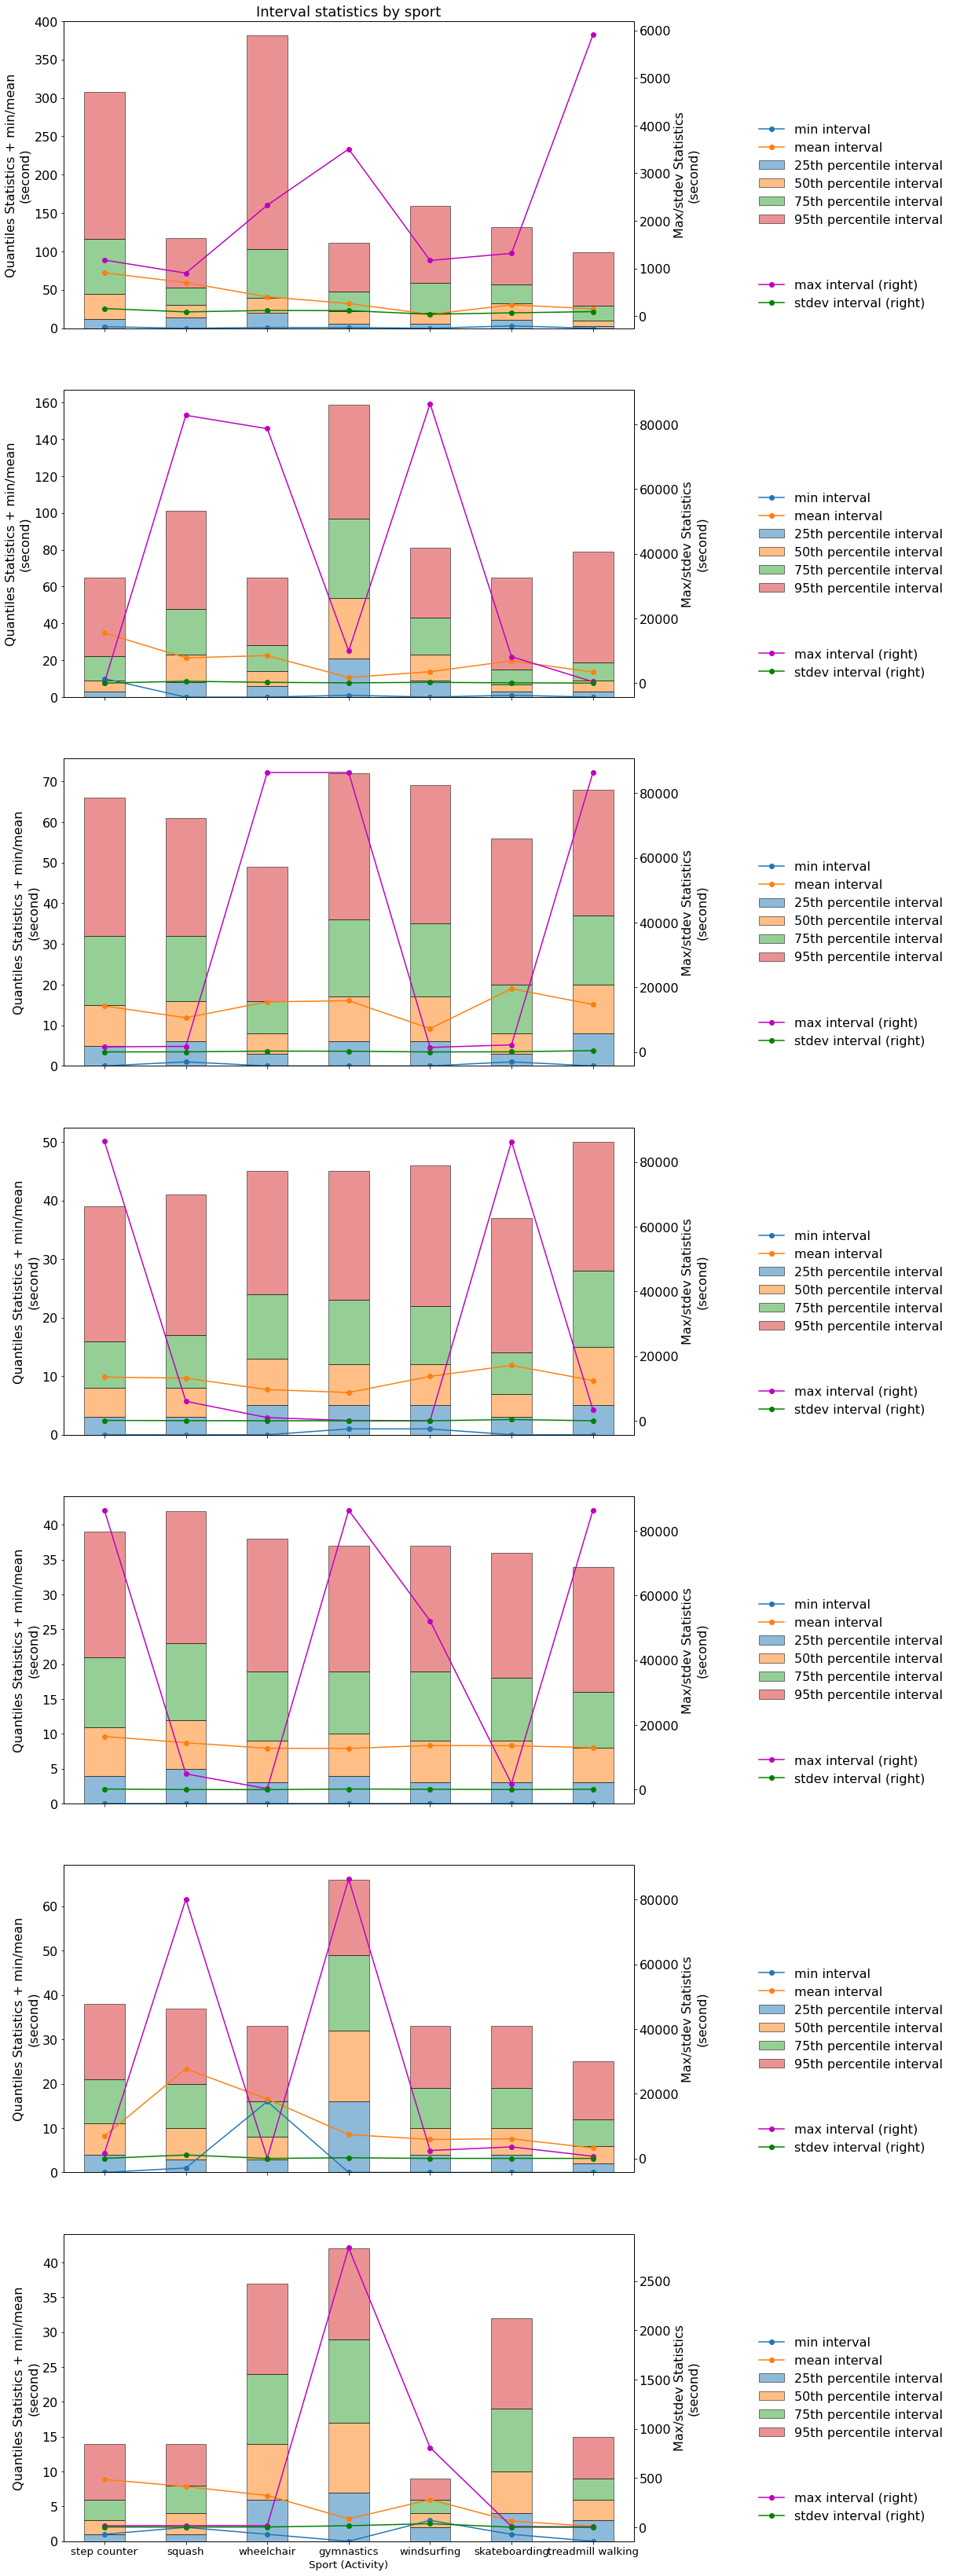

In [28]:
print('\nSummarize statistics of interval sport:')
bar_columns = ['25th percentile interval', '50th percentile interval'
               , '75th percentile interval', '95th percentile interval']
line_columns1 = ['min interval', 'mean interval'] 
line_columns2 = ['max interval', 'stdev interval'] 
interval_statistic_df = interval_statistic_df.sort_values(
    by='95th percentile interval', ascending=False
)
figsize=(13, 59)
fig, axs = plt.subplots(nrows=7, figsize=figsize)

d = axs[0].set_title('Interval statistics by sport', fontsize=18)
for i in range (7):
    interval_statistic_sub_df = interval_statistic_df.iloc[i*7:i*7+7,]
    #interval_statistic_sub_df
    plot1 = interval_statistic_sub_df[['sport'] + bar_columns] \
        .groupby(['sport']).agg(np.mean).plot(
        kind='bar', stacked=True, grid=False, alpha=0.5, edgecolor='black', ax=axs[i], 
    )
    plot2 = interval_statistic_sub_df[['sport'] + line_columns1].plot(x='sport', ax=axs[i], marker='o')
    ax2 = axs[i].twinx()
    plot3 = interval_statistic_sub_df[['sport'] + line_columns2].plot( x='sport', ax=ax2, marker='o', color=['m', 'g'])
    a = axs[i].legend(loc='center left', fontsize=16, bbox_to_anchor=(1.2, 0.5), frameon=False)
    a = ax2.legend(  labels=['max interval (right)', 'stdev interval (right)']
                   , loc="center left", fontsize=16, bbox_to_anchor=(1.2, 0.11), frameon=False)
    b = axs[i].set_xticklabels(interval_statistic_sub_df['sport'],rotation = 'horizontal', fontsize='small')
    c = axs[i].set_xlabel('Sport (Activity)', fontsize='small');
    d = axs[i].set_ylabel('Quantiles Statistics + min/mean\n(second)', fontsize=16);
    e = ax2.set_ylabel('Max/stdev Statistics\n(second)', fontsize=16)
    for tick in axs[i].yaxis.get_major_ticks():
        a = tick.label.set_fontsize(16) 
    ax2.tick_params(axis='y', labelsize=16)
    b = plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

plt.subplots_adjust(hspace=0.2)
plt.show();


Looking at the quantiles statistic, up to 95% of the interval data set does not have the interval larger than 400 seconds, while there are just a few outliers that made the maximum intervals reach up to 86400 seconds (a full days).

### Workout start time
Once again, we use histogram chart to look at the distribution of workouts' started hours, grouped by sport and broken down by gender. We divide a day into intervals of 2 hours, so there are totally 12 buckets.

In [29]:
# Retrive the table of gender, sport and workout_start_time for plotting
start_time_df = df.select('gender', 'sport','workout_start_time').toPandas()


Plotting distribution of workout start time per sport type, break down by gender:


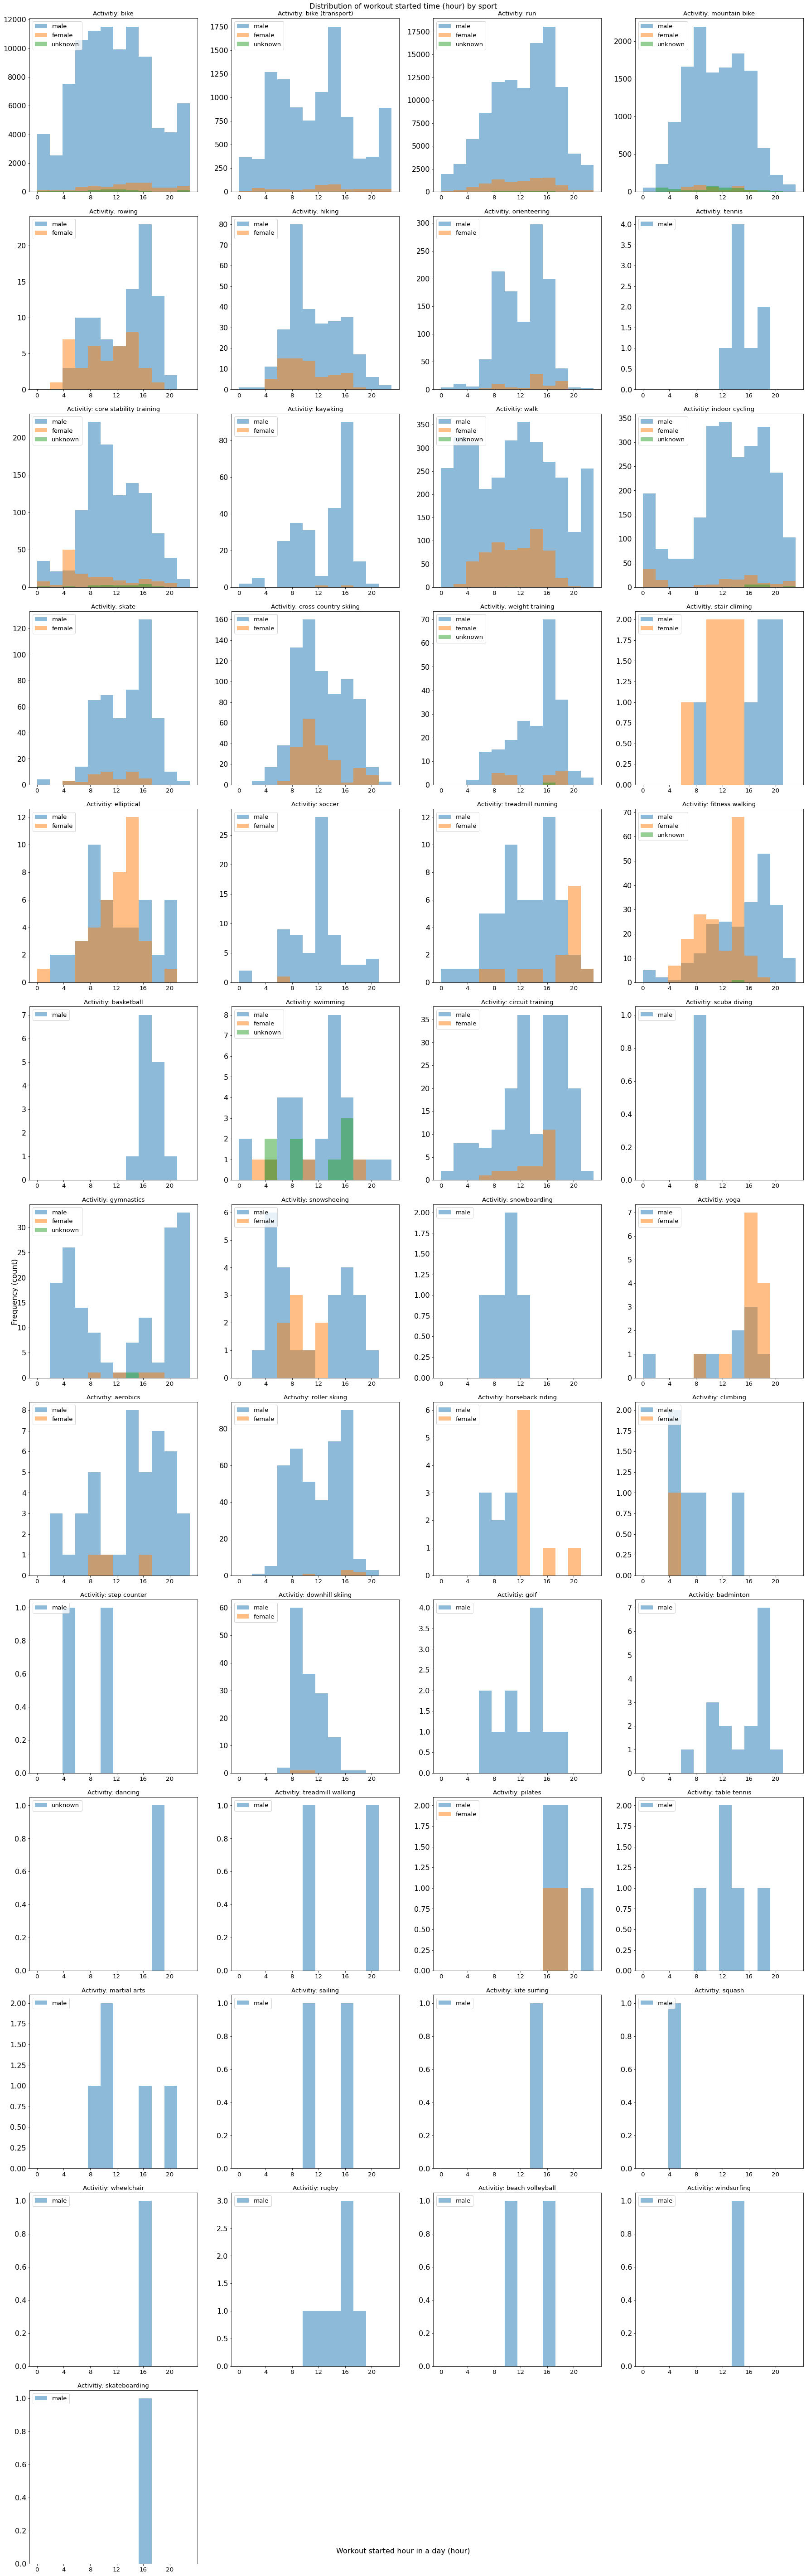

In [30]:
activities = start_time_df['sport'].unique()
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = (plot_size_x + 0.5) * 4 +3, (plot_size_y + 1) * 13 + 1


nrows, ncols = 13, 4
a = fig.subplots_adjust(hspace = 1, wspace = 1)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(figsize_x, figsize_y))
print('\nPlotting distribution of workout start time per sport type, break down by gender:')
a = plt.setp(axs, xticks=[0, 4, 8, 12, 16, 20])
for index, sport in enumerate(activities):
    row_index, col_index = divmod(index, ncols)
    male_start_time_list = start_time_df[(start_time_df.sport == sport) & 
                                            (start_time_df.gender == 'male')]['workout_start_time']
    female_start_time_list = start_time_df[(start_time_df.sport == sport) & 
                                            (start_time_df.gender == 'female')]['workout_start_time']
    unknown_start_time_list = start_time_df[(start_time_df.sport == sport) & 
                                            (start_time_df.gender == 'unknown')]['workout_start_time']
    if len(male_start_time_list) > 0:
        male_dist = axs[row_index, col_index].hist(male_start_time_list,
                                      bins = 12, alpha=0.5, label='male', range=(0, 23))
    if len(female_start_time_list) > 0:    
        female_dist = axs[row_index, col_index].hist(female_start_time_list,
                                      bins = 12, alpha=0.5, label='female', range=(0, 23))
    if len(unknown_start_time_list) > 0:
        unknown_dist = axs[row_index, col_index].hist(unknown_start_time_list,
                                      bins = 12, alpha=0.5, label = 'unknown', range=(0, 23))
    b= axs[row_index, col_index].set_title('Activitiy: ' + sport, fontsize='small')
    a = axs[row_index, col_index].legend(loc="upper left", fontsize='small')
    a = plt.setp(axs[row_index, col_index].get_xticklabels(), fontsize='small')

for i in range(1,4):
    x = axs[12, i].set_visible(False)
a = fig.tight_layout()
z = fig.text(0.5, 1, 'Distribution of workout started time (hour) by sport'
             , ha='center', va='top', transform=fig.transFigure)
y = fig.text(0.5, 0.01, 'Workout started hour in a day (hour)'
             , ha='center', va='bottom', transform=fig.transFigure)
z = fig.text(0.02, 0.5, 'Frequency (count)', va='center', rotation='vertical');